# Setup

In [26]:
import os
# import googleapiclient.discovery you don't need to use these libraries unless you really want to run the bad api code
# import googleapiclient.errors
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

In [27]:
with open('secret/secret.txt') as f:
    api_key = f.readline().strip()

youtube = googleapiclient.discovery.build("youtube", "v3", developerKey=api_key)

# Load and Cache

In [28]:
def get_and_add_playlist_id_to_dataframe(dataframe, channel_ids):
    playlist_ids = []
    for channel_id in channel_ids:
        request = youtube.channels().list(
            part="contentDetails",
            id=channel_id
        )
        response = request.execute()
        playlist_ids.append(response['items'][0]['contentDetails']['relatedPlaylists']['uploads'])
    dataframe['playlist_id'] = playlist_ids
    return dataframe

In [29]:
import ast

def get_video_data(video_data_path, channel_data):
    if os.path.exists(video_data_path):
        video_data = pd.read_csv(video_data_path)
    else:
        video_data = pd.DataFrame(columns=["channel_id","video_id", "video_title", "publish_date" ,"view_count", "like_count", "dislike_count", "comment_count", "default_language", "duration","has_paid_product_placement"])

        try:
            for id,channel_id in zip(channel_data["video_id"],channel_data["channel_id"]):

                video_request = youtube.videos().list(
                    part="snippet,statistics,contentDetails",
                    id=id
                )

                video_response = video_request.execute()

                for video in video_response["items"]:

                    try:
                        video_id = video["id"]
                    except KeyError:
                        video_id = float('nan')
                    try:
                        view_count = video["statistics"]["viewCount"]
                    except KeyError:
                        view_count = float('nan')
                    try:
                        like_count = video["statistics"]["likeCount"]
                    except KeyError:
                        like_count = float('nan')
                    try:
                        dislike_count = video["statistics"]["dislikeCount"]
                    except KeyError:
                        dislike_count = float('nan')
                    try:
                        comment_count = video["statistics"]["commentCount"]
                    except KeyError:
                        comment_count = float('nan')
                    try:
                        video_title = video["snippet"]["title"]
                    except KeyError:
                        video_title = float('nan')
                    try:
                        publish_date = video["snippet"]["publishedAt"]
                    except KeyError:
                        publish_date = float('nan')
                    try:
                        default_language = video["snippet"]["defaultLanguage"]
                    except KeyError:
                        default_language = float('nan')
                    try:
                        duration = video["contentDetails"]["duration"]
                    except KeyError:
                        duration = float('nan')
                    try:
                        has_paid_product_placement = video["contentDetails"]["hasPaidProductPlacement"]
                    except KeyError:
                        has_paid_product_placement = float('nan')
                    

                    row = pd.DataFrame({
                        "video_id": [video_id],
                        "channel_id": [channel_id],
                        "video_title": [video_title],
                        "view_count": [view_count],
                        "like_count": [like_count],
                        "dislike_count": [dislike_count],
                        "comment_count": [comment_count],
                        "publish_date": [publish_date],
                        "default_language": [default_language],
                        "duration": [duration],
                        "has_paid_product_placement": [has_paid_product_placement]
                    })

                    video_data = pd.concat([video_data, row], ignore_index=True)

        except Exception as e:
            print(f"Error {e}")
            video_response = {"items": []}

        if len(video_data) > 0:    
            video_data.to_csv(video_data_path, index=False)
    
    return video_data

In [30]:
channel_data_path = f"ChannelID_Data.csv"
video_data_path = f"video_data.csv"

channel_data =  pd.read_csv(channel_data_path)
video_data = pd.read_csv(video_data_path)
 

# Clean Data

In [31]:
channel_data = channel_data.drop(columns=['Unnamed: 0'])
video_data = video_data.drop(columns=['dislike_count'])

# merge by channel_id
merged_data = pd.merge(channel_data, video_data, on="channel_id")
display(merged_data.head(1))

,channel_title,channel_id,description,view_count_x,subscriber_count,video_count,Category,playlist_id,video_id,video_title,publish_date,view_count_y,like_count,comment_count,default_language,duration,has_paid_product_placement
0,T-Series,UCq-Fj5jknLsUf-MWSy4_brA,"""Music can change the world"". T-Series is Indi...",267112024995,274000000,21739,Music,UUq-Fj5jknLsUf-MWSy4_brA,BBAyRBTfsOU,"Vaaste Song: Dhvani Bhanushali, Tanishk Bagchi...",2019-04-06T11:56:37Z,1.613914e+09,13290150.0,363862.0,NaN,PT4M27S,NaN


In [32]:
#rename Category to category
merged_data.rename(columns = {'Category':'category'}, inplace = True)

#rename view_x to channel_view_count
merged_data.rename(columns = {'view_count_x':'channel_view_count'}, inplace = True)

#rename view_y to video_view_count
merged_data.rename(columns = {'view_count_y':'video_view_count'}, inplace = True)

# duration in seconds
merged_data["duration"] = merged_data["duration"].apply(lambda x: pd.to_timedelta(x).seconds)

# convert publish_date to datetime
merged_data["publish_date"] = pd.to_datetime(merged_data["publish_date"])

# change default_language nan to "none"
merged_data["default_language"] = merged_data["default_language"].fillna("none")

# drop has paid product placement
merged_data = merged_data.drop(columns=["has_paid_product_placement"])

# drop nan values
merged_data = merged_data.dropna()

# convert number data to ints
merged_data["video_view_count"] = merged_data["video_view_count"].astype(int)
merged_data["channel_view_count"] = merged_data["channel_view_count"].astype(int)
merged_data["like_count"] = merged_data["like_count"].astype(int)
merged_data["comment_count"] = merged_data["comment_count"].astype(int)
merged_data["subscriber_count"] = merged_data["subscriber_count"].astype(int)
merged_data["video_count"] = merged_data["video_count"].astype(int)

display(merged_data.head(3))

,channel_title,channel_id,description,channel_view_count,subscriber_count,video_count,category,playlist_id,video_id,video_title,publish_date,video_view_count,like_count,comment_count,default_language,duration
0,T-Series,UCq-Fj5jknLsUf-MWSy4_brA,"""Music can change the world"". T-Series is Indi...",267112024995,274000000,21739,Music,UUq-Fj5jknLsUf-MWSy4_brA,BBAyRBTfsOU,"Vaaste Song: Dhvani Bhanushali, Tanishk Bagchi...",2019-04-06 11:56:37+00:00,1613914385,13290150,363862,none,267
1,T-Series,UCq-Fj5jknLsUf-MWSy4_brA,"""Music can change the world"". T-Series is Indi...",267112024995,274000000,21739,Music,UUq-Fj5jknLsUf-MWSy4_brA,sCbbMZ-q4-I,"Lut Gaye (Full Song) Emraan Hashmi, Yukti | Ju...",2021-02-17 06:30:11+00:00,1422725378,11124151,342825,none,298
2,T-Series,UCq-Fj5jknLsUf-MWSy4_brA,"""Music can change the world"". T-Series is Indi...",267112024995,274000000,21739,Music,UUq-Fj5jknLsUf-MWSy4_brA,JFcgOboQZ08,DILBAR Lyrical | Satyameva Jayate |John Abraha...,2018-07-09 13:50:00+00:00,1338394851,5713894,190363,none,199


In [33]:
# add is in covid column (2020-2021)
merged_data["is_in_covid"] = merged_data["publish_date"].apply(lambda x: 1 if x.year >= 2020 and x.year <= 2021 else 0)

# engagment_comments (comments/video_view)
merged_data["engagement_comments"] = merged_data["comment_count"] / merged_data["video_view_count"]

# engagment_likes (likes/video_view)
merged_data["engagement_likes"] = merged_data["like_count"] / merged_data["video_view_count"]

# engagment_subscribers (video_view/subscribers)
merged_data["engagement_subscribers"] = merged_data["video_view_count"] / merged_data["subscriber_count"]

# view per subscriber (channel_view/subscribers)
merged_data["view_per_subscriber"] = merged_data["channel_view_count"] / merged_data["subscriber_count"]

# video view per total channel view (video_view/channel_view)
merged_data["video_view_per_total_channel_view"] = merged_data["video_view_count"] / merged_data["channel_view_count"]

# video views per video count (video_view/video_count)
merged_data["video_views_per_video_count"] = merged_data["channel_view_count"] / merged_data["video_count"]

display(merged_data.head(3))

,channel_title,channel_id,description,channel_view_count,subscriber_count,video_count,category,playlist_id,video_id,video_title,...,comment_count,default_language,duration,is_in_covid,engagement_comments,engagement_likes,engagement_subscribers,view_per_subscriber,video_view_per_total_channel_view,video_views_per_video_count
0,T-Series,UCq-Fj5jknLsUf-MWSy4_brA,"""Music can change the world"". T-Series is Indi...",267112024995,274000000,21739,Music,UUq-Fj5jknLsUf-MWSy4_brA,BBAyRBTfsOU,"Vaaste Song: Dhvani Bhanushali, Tanishk Bagchi...",...,363862,none,267,0,0.000225,0.008235,5.890198,974.861405,0.006042,1.228723e+07
1,T-Series,UCq-Fj5jknLsUf-MWSy4_brA,"""Music can change the world"". T-Series is Indi...",267112024995,274000000,21739,Music,UUq-Fj5jknLsUf-MWSy4_brA,sCbbMZ-q4-I,"Lut Gaye (Full Song) Emraan Hashmi, Yukti | Ju...",...,342825,none,298,1,0.000241,0.007819,5.192428,974.861405,0.005326,1.228723e+07
2,T-Series,UCq-Fj5jknLsUf-MWSy4_brA,"""Music can change the world"". T-Series is Indi...",267112024995,274000000,21739,Music,UUq-Fj5jknLsUf-MWSy4_brA,JFcgOboQZ08,DILBAR Lyrical | Satyameva Jayate |John Abraha...,...,190363,none,199,0,0.000142,0.004269,4.884653,974.861405,0.005011,1.228723e+07


# Display Data

In [34]:
import matplotlib.gridspec as gridspec

def scatter_plot(x, x_title, y, y_title, in_data, out_data):
    # Get unique categories
    categories = in_data["category"].unique()

    # Set up figure size for each category
    for i, category in enumerate(categories):
        # Separate the data for the current category
        category_data = in_data[in_data["category"] == category]
        category_filtered_out_data = out_data[out_data["category"] == category]
        
        # Create a figure for scatter plot
        fig = plt.figure(figsize=(7, 6))
        
        # Choose a color from Seaborn's color palette
        color = sns.color_palette("husl", len(categories))[i]
        
        # Scatter plot (highlighted data within duration < 2000)
        ax = plt.subplot()
        sns.regplot(x=x, y=y, data=category_data, ax=ax, color=color)

        # Plot the filtered-out data (background points with different color and transparency)
        sns.scatterplot(x=x, y=y, data=category_filtered_out_data, ax=ax, 
                        color='gray', alpha=0.4, label="Filtered Out", s=50)
        
        # Calculate Pearson correlation
        pear = pearsonr(category_data[x], category_data[y])
        
        # Set title and labels
        ax.set_title(f"Category: {category} | Pearson Correlation: {pear[0]:.3f} | P-Value: {pear[1]:.3f}")
        ax.set_xlabel(x_title)
        ax.set_ylabel(y_title)
        
        # Show the scatter plot for the current category
        plt.tight_layout()
        plt.show()

def distribution_plot(x, x_title, in_data):
    # Get unique categories
    categories = in_data["category"].unique()

    # Set up figure size and create a figure for the distribution plot
    fig = plt.figure(figsize=(7, 6))
    ax = plt.subplot()

    # Plot each category on the same axis
    for i, category in enumerate(categories):
        # Separate the data for the current category
        category_data = in_data[in_data["category"] == category]

        # Choose a color from Seaborn's color palette
        color = sns.color_palette("husl", len(categories))[i]


        # Distribution plot (KDE), normalized and without fill
        sns.kdeplot(category_data[x], ax=ax, color=color, fill=True, common_norm=True, label=category, log_scale=True, alpha=0.05)

    # Set plot title and labels
    ax.set_title(f"{x_title} Distribution by Category")
    ax.set_xlabel(f" log scale {x_title}")
    
    # Display the legend for categories
    ax.legend(title="Category")

    # Show the distribution plot
    plt.tight_layout()
    plt.show()


In [35]:
no_shorts = merged_data[merged_data["duration"] > 60]
only_shorts = merged_data[merged_data["duration"] <= 60]

# Scatter and regression

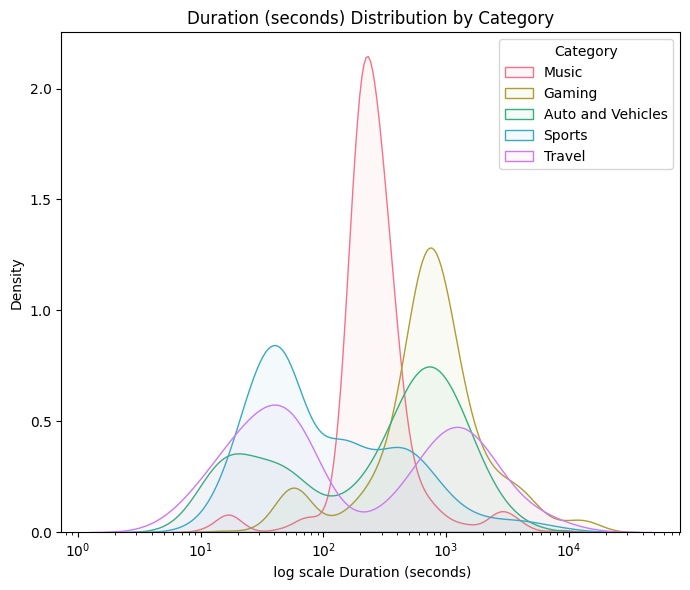

In [36]:
distribution_plot("duration","Duration (seconds)",merged_data)

In [37]:
# scatter_plot("duration","Duration (seconds)","video_view_count","Video Views",no_shorts,only_shorts)

In [38]:
# distribution_plot("video_view_count","Video Views",no_shorts)

In [39]:
# scatter_plot("duration","Duration (seconds)","comment_count","Comment Count",no_shorts,only_shorts)

In [40]:
# distribution_plot("comment_count","Comment Count",no_shorts)

In [41]:
def bar_plot_compare_multiple_columns(cat_col, cols, col_titles, data):
    # Get unique categories
    categories = data[cat_col].unique()

    # Prepare data for bar plot
    bar_data = []
    for category in categories:
        category_data = data[data[cat_col] == category]
        means = [category_data[col].mean() for col in cols]
        bar_data.append([category] + means)
    
    # Convert to DataFrame for easier plotting
    bar_df = pd.DataFrame(bar_data, columns=[cat_col] + col_titles)

    # Melt the DataFrame to have it in long format suitable for Seaborn
    bar_df_melted = pd.melt(bar_df, id_vars=[cat_col], value_vars=col_titles, 
                            var_name='Metric', value_name='Mean Value')

    # Create bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=cat_col, y='Mean Value', hue='Metric', data=bar_df_melted)
    
    # Set plot labels and title
    plt.xlabel('Category')
    plt.ylabel('Mean Value')
    plt.title(f'Comparison of Metrics by {cat_col}')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Bar plots comparing engagment for videos

In [42]:
# bar_plot_compare_multiple_columns("category",["video_view_count","comment_count"],["Video Views","Comment Count"],no_shorts)


In [43]:
# bar_plot_compare_multiple_columns("category",["video_view_count","like_count"],["Video Views","Like Count"],no_shorts)

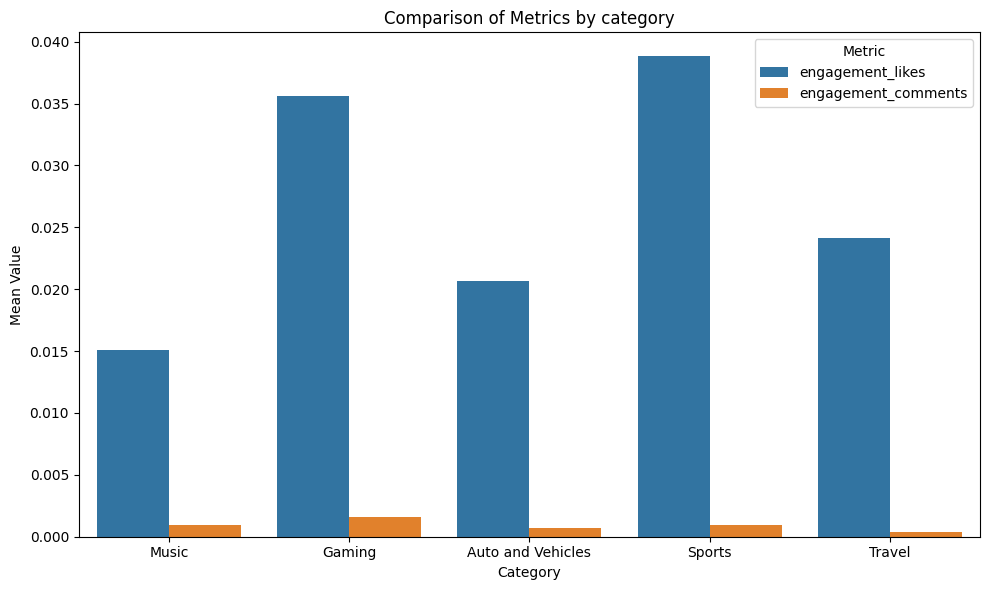

In [44]:
bar_plot_compare_multiple_columns("category",["engagement_likes","engagement_comments"],["engagement_likes","engagement_comments"],merged_data)

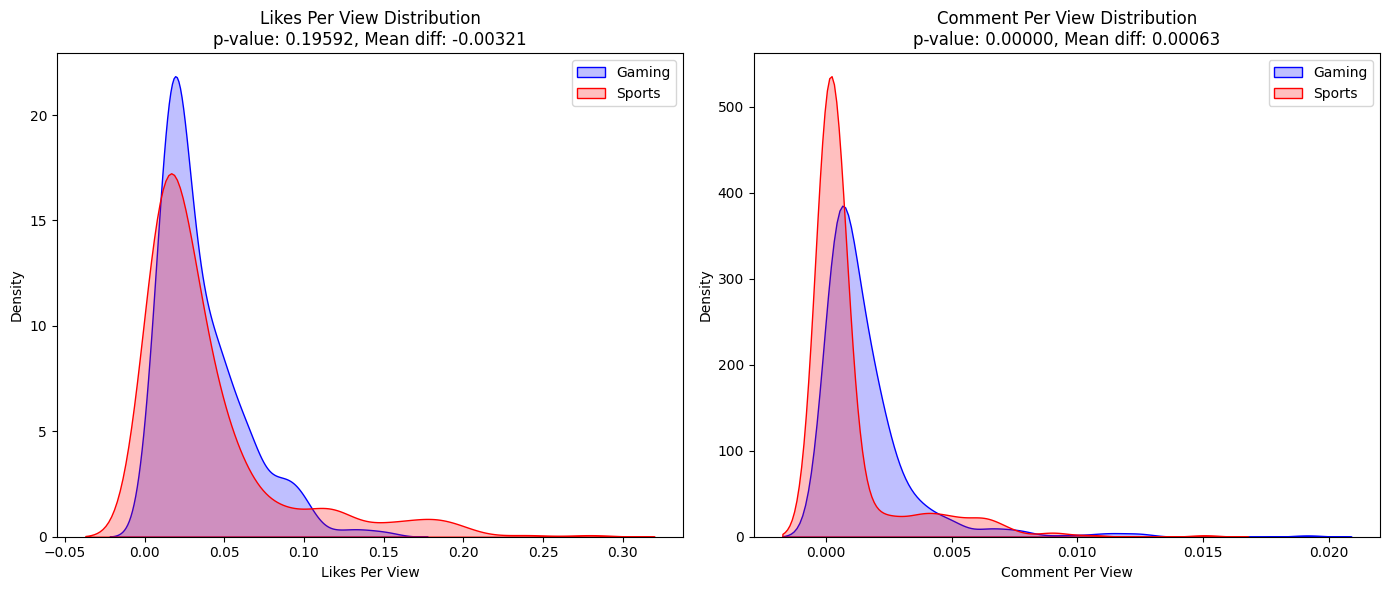

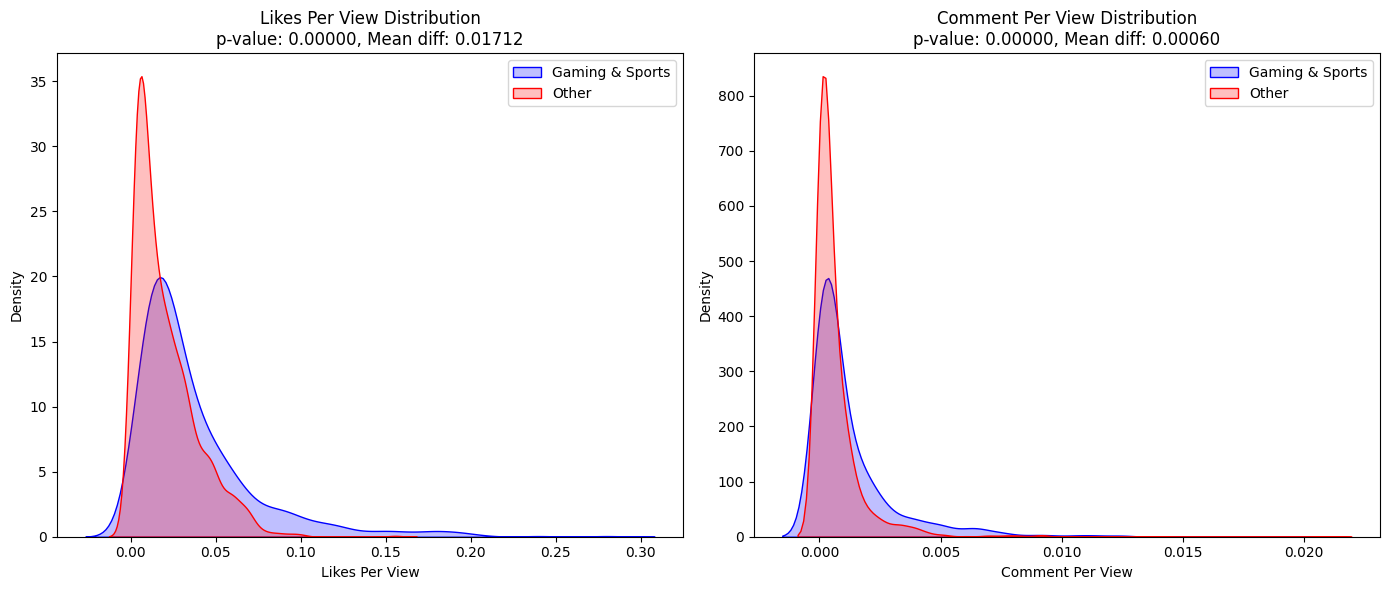

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def compare_two_categories_distributions(category1, category2, x_title, metrics, data):
    # Subset the data for the two categories
    data_cat1 = data[data["category"] == category1]
    data_cat2 = data[data["category"] == category2]

    # Calculate the means of each metric for both categories
    mean_likes_cat1 = data_cat1[metrics[0]].mean()
    mean_likes_cat2 = data_cat2[metrics[0]].mean()
    mean_comments_cat1 = data_cat1[metrics[1]].mean()
    mean_comments_cat2 = data_cat2[metrics[1]].mean()

    # Calculate effect sizes (mean differences)
    effect_size_likes = mean_likes_cat1 - mean_likes_cat2
    effect_size_comments = mean_comments_cat1 - mean_comments_cat2

    # Perform t-tests for both metrics
    ttest_likes = stats.ttest_ind(data_cat1[metrics[0]], data_cat2[metrics[0]], nan_policy='omit')
    ttest_comments = stats.ttest_ind(data_cat1[metrics[1]], data_cat2[metrics[1]], nan_policy='omit')

    # Set up a side-by-side plot (2 columns, 1 row)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot distributions for engagement_likes
    sns.kdeplot(data_cat1[metrics[0]], ax=axes[0], label=category1, color='blue', fill=True)
    sns.kdeplot(data_cat2[metrics[0]], ax=axes[0], label=category2, color='red', fill=True)
    axes[0].set_title(f"Likes Per View Distribution\np-value: {ttest_likes.pvalue:.5f}, Mean diff: {effect_size_likes:.5f}")
    axes[0].set_xlabel("Likes Per View")
    axes[0].legend()

    # Plot distributions for engagement_comments
    sns.kdeplot(data_cat1[metrics[1]], ax=axes[1], label=category1, color='blue', fill=True)
    sns.kdeplot(data_cat2[metrics[1]], ax=axes[1], label=category2, color='red', fill=True)
    axes[1].set_title(f"Comment Per View Distribution\np-value: {ttest_comments.pvalue:.5f}, Mean diff: {effect_size_comments:.5f}")
    axes[1].set_xlabel("Comment Per View")
    axes[1].legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

# combine gaminga nd sports into one category and everythoiing else into other
gaming_and_sports_data = merged_data.copy()
gaming_and_sports_data["category"] = gaming_and_sports_data["category"].apply(lambda x: "Gaming & Sports" if x in ["Gaming", "Sports"] else "Other")

# Example usage
compare_two_categories_distributions("Gaming", "Sports", "Category Comparison", 
                                     ["engagement_likes", "engagement_comments"], merged_data)

compare_two_categories_distributions("Gaming & Sports", "Other", "Category Comparison", 
                                     ["engagement_likes", "engagement_comments"], gaming_and_sports_data)


In [46]:
# plot average views per category by year line plot

def line_plot_average_views_per_category_by_year(data):
    # Convert publish_date to datetime if not already
    data["publish_date"] = pd.to_datetime(data["publish_date"])
    data["year"] = data["publish_date"].dt.year

    # Group the data by year and category, and calculate the mean of video_view_count
    grouped_data = data.groupby(["year", "category"])["video_view_count"].sum().reset_index()

    # Create line plot
    plt.figure(figsize=(12, 8))
    sns.lineplot(x='year', y='video_view_count', hue='category', data=grouped_data)
    
    # Set plot labels and title
    plt.xlabel('Year')
    plt.ylabel('Average Video Views')
    plt.title('Average Video Views per Category by Year')
    
    # Display the plot
    plt.tight_layout()
    plt.show()




# Covid Compare

In [47]:
# line_plot_average_views_per_category_by_year(no_shorts)

In [48]:
def distribution_plot_covid(x, x_title, in_data):
    # Get unique categories
    categories = in_data["category"].unique()

    # Set up figure size for each category
    for i, category in enumerate(categories):
        # Separate the data for the current category
        category_data = in_data[in_data["category"] == category]
        
        # Create a figure for the distribution plot
        fig = plt.figure(figsize=(7, 6))
        
        # Choose a color from Seaborn's color palette
        color = sns.color_palette("husl", len(categories))[i]
        
        # Distribution plot (KDE)
        ax = plt.subplot()

        sns.kdeplot(category_data[x], ax=ax, color=color, fill=True)
        ax.set_title(f"{x_title} Distribution for {category}")
        ax.set_xlabel(x_title)


        # Calculate the mean of x and add a vertical line
        mean_x = category_data[x].mean()
        ax.axvline(mean_x, color=color, linestyle='--', linewidth=2)
        
        # Add a label at the mean line
        #check for date time
        if x == "publish_date":
            ax.text(mean_x, ax.get_ylim()[1] * 0.9, f'Mean: {mean_x.strftime("%Y-%m-%d")}', color=color, 
                ha='center', va='top', fontsize=10, backgroundcolor='white', rotation=90)
        else:
            ax.text(mean_x, ax.get_ylim()[1] * 0.9, f'Mean: {mean_x:.2f}', color=color, 
                ha='center', va='top', fontsize=10, backgroundcolor='white', rotation=90)
            
        # add in covid range
        _2020_date = pd.to_datetime("2020-01-01")
        _2021_date = pd.to_datetime("2021-12-31")
        _2020_half_date = pd.to_datetime("2020-12-31")
        ax.axvline(_2020_date, color='red', linestyle='--', linewidth=2)
        ax.axvline(_2021_date, color='red', linestyle='--', linewidth=2)

        #shade the covid range
        ax.axvspan(_2020_date, _2021_date, color='red', alpha=0.1)


        ax.text(_2020_half_date, ax.get_ylim()[1]*.1, f'COVID-19', color='red', 
                 ha='center', va='top', fontsize=10, backgroundcolor='white')
        
        # Show the distribution plot for the current category
        plt.tight_layout()
        plt.show()

In [49]:
# show distribution of videos by publish date
# distribution_plot_covid("publish_date","Video Publish Date",no_shorts)

LinregressResult(slope=np.float64(0.31894356608519997), intercept=np.float64(31434492.303360004), rvalue=np.float64(0.2644571933154239), pvalue=np.float64(0.075725581620709), stderr=np.float64(0.17534289190982102), intercept_stderr=np.float64(4924364.784139352))

LinregressResult(slope=np.float64(0.0012993408688341096), intercept=np.float64(15668272.289649595), rvalue=np.float64(0.8133513867162923), pvalue=np.float64(6.4849649793110035e-12), stderr=np.float64(0.00014011089822504942), intercept_stderr=np.float64(3356202.4596433914))

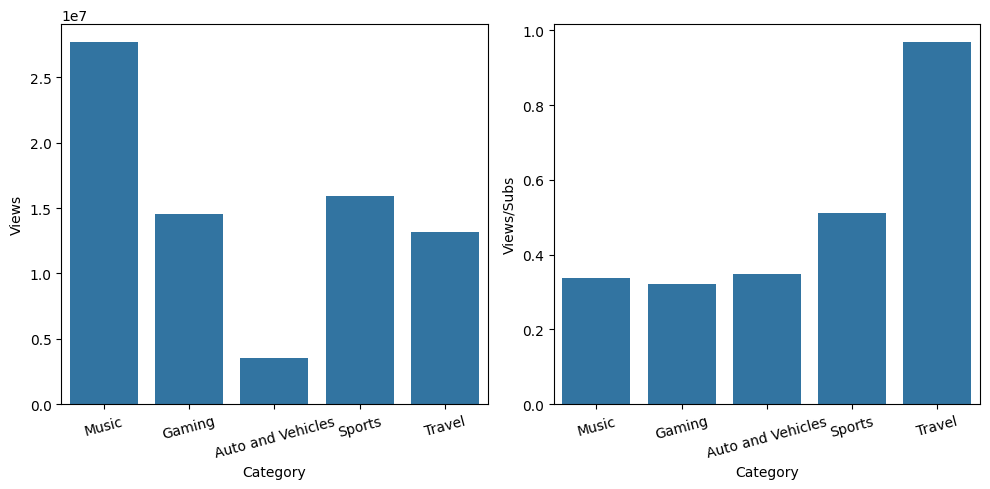

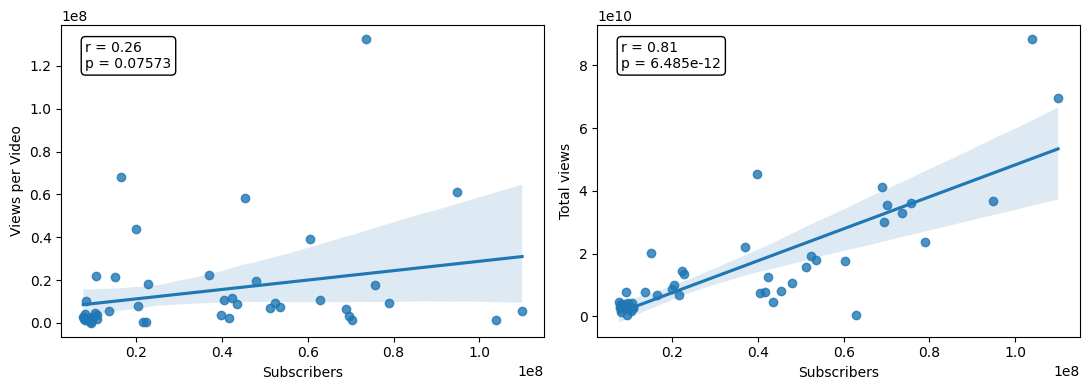

In [50]:
channels=pd.read_csv('ChannelID_Data.csv')
channels = channels[channels.video_count>0]
channels['viewpervideo']=channels.view_count/channels.video_count
channels['engagement_subs']=channels.viewpervideo/channels.subscriber_count

fig, ax = plt.subplots(figsize=(10, 5), ncols=2)

# First barplot (Views per Video)
sns.barplot(channels, x='Category', y='viewpervideo', errorbar=None, ax=ax[0])
ax[0].set_ylabel('Views')
ax[0].set_xlabel('Category')
ax[0].tick_params(axis='x', rotation=15)  # Rotate x labels

# Second barplot (Views/Subs)
sns.barplot(channels, x='Category', y='engagement_subs', errorbar=None, ax=ax[1])
ax[1].set_ylabel('Views/Subs')
ax[1].set_xlabel('Category')
ax[1].tick_params(axis='x', rotation=15)  # Rotate x labels

plt.tight_layout()
plt.savefig('fig2.jpg', dpi=300)

slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(channels['subscriber_count'].drop(0), channels['viewpervideo'].drop(0))
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(channels['subscriber_count'].drop(0), channels['view_count'].drop(0))

fig, ax = plt.subplots(figsize=(11, 4), ncols=2, nrows=1)

sns.regplot(channels.drop(0), y='viewpervideo', x='subscriber_count', ax=ax[0])
ax[0].set_ylabel('Views per Video')
ax[0].set_xlabel('Subscribers')
ax[0].annotate(f'r = {r_value1:.2f}\np = {p_value1:.5f}', xy=(0.05, 0.95), xycoords='axes fraction', 
               fontsize=10, ha='left', va='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

sns.regplot(channels.drop(0), y='view_count', x='subscriber_count', ax=ax[1])
ax[1].set_ylabel('Total views')
ax[1].set_xlabel('Subscribers')
ax[1].annotate(f'r = {r_value2:.2f}\np = {p_value2:.3e}', xy=(0.05, 0.95), xycoords='axes fraction', 
               fontsize=10, ha='left', va='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

plt.tight_layout()
plt.savefig('fig3.jpg', dpi=300)

display(stats.linregress(channels.drop(0).viewpervideo,channels.drop(0).subscriber_count))
display(stats.linregress(channels.drop(0).view_count,channels.drop(0).subscriber_count))
